In [42]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Figures inline and set visualization style
%matplotlib inline
sns.set()

In [4]:
# Import test and train datasets
df_train = pd.read_csv('data/titanic_train.csv')
df_test = pd.read_csv('data/titanic_test.csv')

# View first lines of training data
df_train.head(n=4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


There are only 714 non-null values for the 'Age' column in a DataFrame with 891 rows. This means that are are 177 null or missing values. 

In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Visual Exploratory Data Analysis

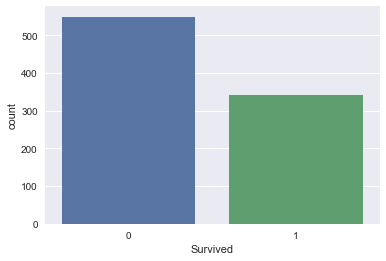

In [7]:
sns.countplot(x='Survived', data=df_train)

Difference between Male and Female

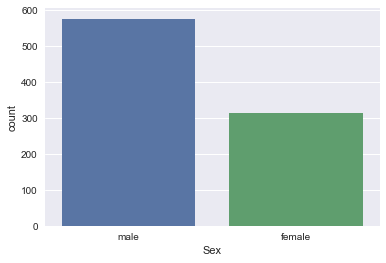

In [8]:
sns.countplot(x='Sex', data=df_train);

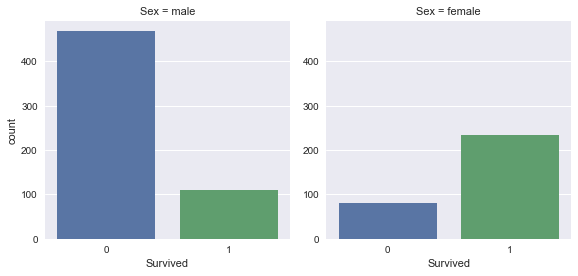

In [9]:
sns.factorplot(x='Survived', col='Sex', kind='count', data=df_train);

Women were more likely to survive than men.

In [10]:
df_train.groupby(['Sex']).Survived.sum()

Sex
female    233
male      109
Name: Survived, dtype: int64

Let's calculate the proportion

In [11]:
print("Female: ", df_train[df_train.Sex == 'female'].Survived.sum()/df_train[df_train.Sex == 'female'].Survived.count())
print("Male: ",df_train[df_train.Sex == 'male'].Survived.sum()/df_train[df_train.Sex == 'male'].Survived.count())

Female:  0.742038216561
Male:  0.188908145581


74% of women survived, while 19% of men survived.

Now we are going to analyse the Pclass

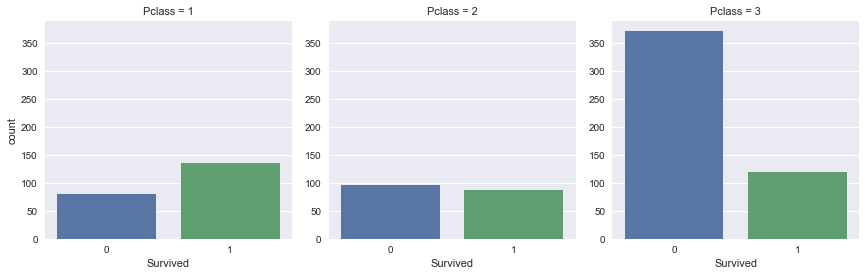

In [12]:
sns.factorplot(x='Survived', col='Pclass', kind='count', data=df_train);

Passengers that travelled in first class were more likely to survive. On the other hand, passengers travelling in third class were more unlikely to survive. 

Now the which port they embarked...

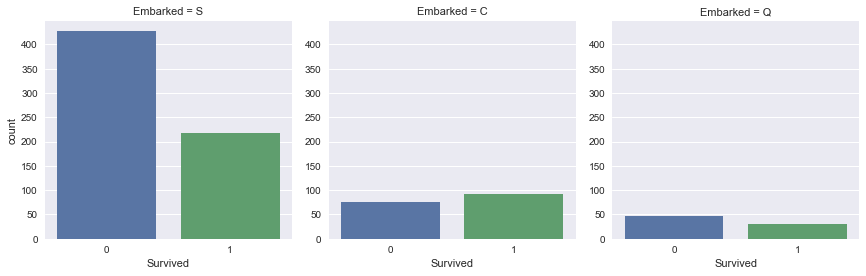

In [14]:
sns.factorplot(x='Survived', col='Embarked', kind='count', data=df_train);

Passengers that embarked in Southampton were less likely to survive. 

Is it relevant how much they payed?


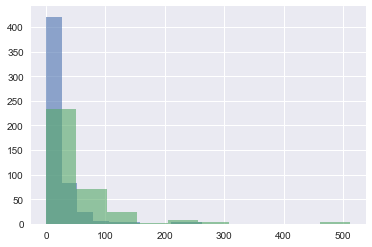

In [15]:
df_train.groupby('Survived').Fare.hist(alpha=0.6);

It looks as though those that paid more had a higher chance of surviving.

And what about their age?

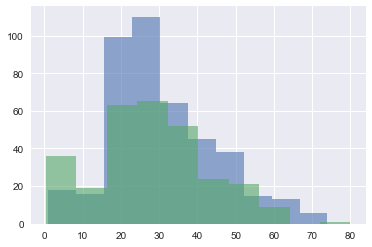

In [21]:
df_train.groupby('Survived').Age.hist(alpha=0.6);

It seems that children were more likely to survive

Let's combine Fare and Age

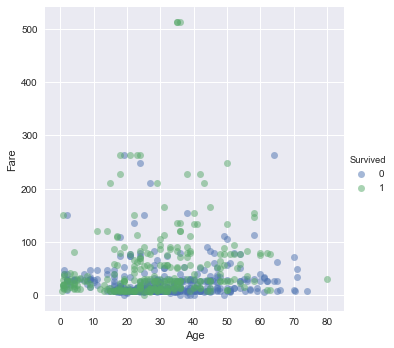

In [22]:
sns.lmplot(x='Age', y='Fare', hue='Survived', data=df_train, fit_reg=False, scatter_kws={'alpha':0.5});

It looks like those who survived either paid quite a bit for their ticket or they were young.

# Building Models

In [23]:
# Store target variable of training data in a safe place
survived_train = df_train.Survived

# Concatenate training and test sets
data = pd.concat([df_train.drop(['Survived'], axis=1), df_test])

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


There are 2 numerical variables that have missing values: 'Age' and 'Fare'

In [25]:
data['Age'] = data.Age.fillna(data.Age.median())
data['Fare'] = data.Fare.fillna(data.Fare.median())

# Check out info of data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


We need to change 'male' and 'female' to numbers. You do this because most machine learning models work input features that are numerical.

In [26]:
data = pd.get_dummies(data, columns=['Sex'], drop_first=True)
data.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,1,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,0
4,5,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,1


Now we will create our first model using 'Sex_male', 'Fare', 'Age','Pclass', 'SibSp'.

In [27]:
# Select columns and view head
data = data[['Sex_male', 'Fare', 'Age','Pclass', 'SibSp']]
data.head()

,Sex_male,Fare,Age,Pclass,SibSp
0,1,7.2500,22.0,3,1
1,0,71.2833,38.0,1,1
2,0,7.9250,26.0,3,0
3,0,53.1000,35.0,1,1
4,1,8.0500,35.0,3,0


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 5 columns):
Sex_male    1309 non-null uint8
Fare        1309 non-null float64
Age         1309 non-null float64
Pclass      1309 non-null int64
SibSp       1309 non-null int64
dtypes: float64(2), int64(2), uint8(1)
memory usage: 52.4 KB


Spliting it back into training and test sets

In [39]:
data_train = data.iloc[:891]
data_test = data.iloc[891:]

In [40]:
X = data_train.values
test = data_test.values
y = survived_train.values

Using the Random Forest Classifier

In [51]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth = 10, min_samples_split=2, n_estimators = 100, random_state = 1)
my_forest = forest.fit(X, y)
Y_pred = my_forest.predict(test)
df_test['Survived'] = Y_pred
df_test[['PassengerId', 'Survived']].to_csv('data/Random_Forest.csv', index=False)

The score in Kaggle was: 0.77990